# Model Comparison

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

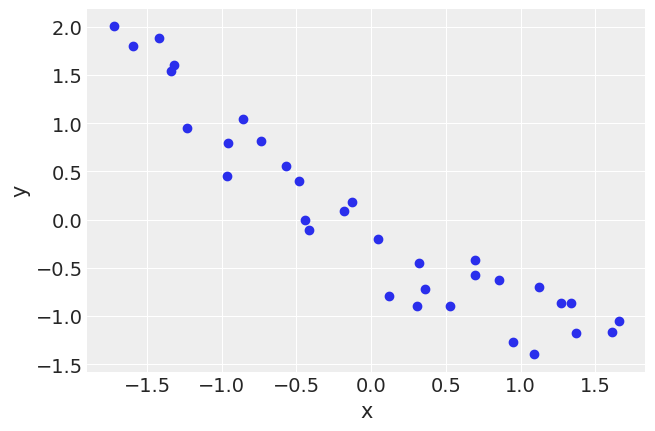

In [3]:
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / \
    x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('B11197_05_01.png', dpi=300)

In [4]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + β * x_1s[0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_l = pm.sample(2000)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, x_1s)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 1981.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 890.01draws/s] 
The acceptance probability does not match the target. It is 0.8789351055578033, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796592120300201, but should be close to 0.8. Try to increase the number of tuning steps.


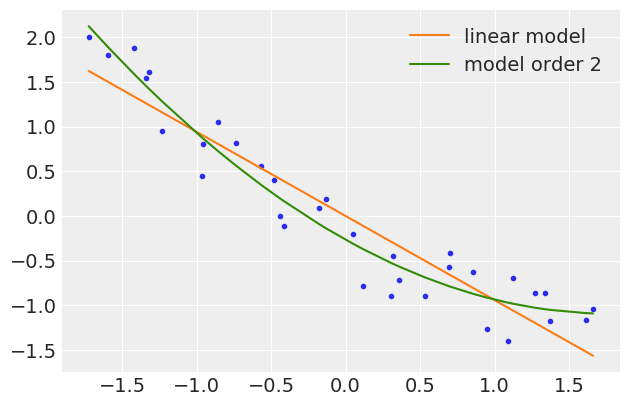

In [5]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p) 

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()
plt.savefig('B11197_05_02.png', dpi=300)

## Posterior predictive checks

In [6]:
y_l = pm.sample_posterior_predictive(trace_l, 2000, model=model_l)['y_pred']
y_p = pm.sample_posterior_predictive(trace_p, 2000, model=model_p)['y_pred']

100%|██████████| 2000/2000 [00:01<00:00, 1319.97it/s]


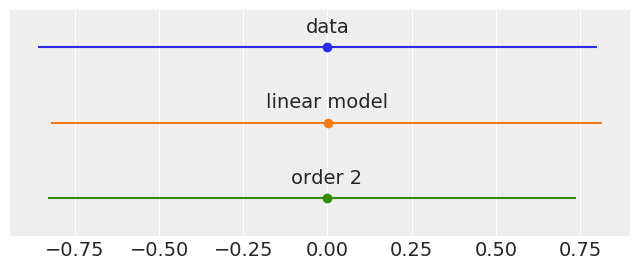

In [7]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
plt.savefig('B11197_05_03.png', dpi=300)

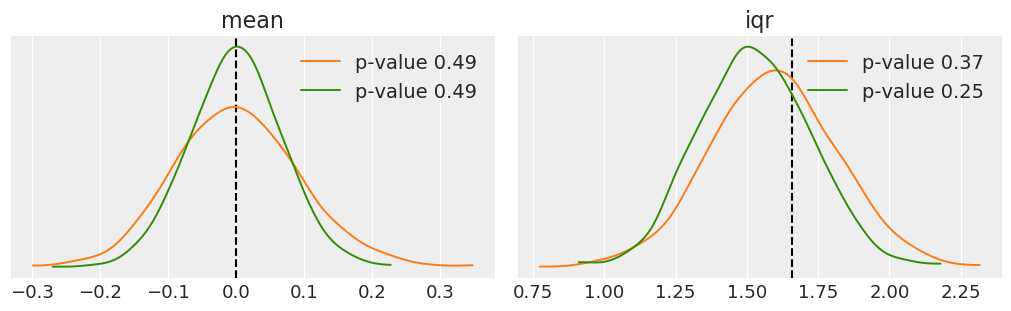

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)


def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))


for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
                    label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()
plt.savefig('B11197_05_04.png', dpi=300)

# Occam's razor – simplicity and accuracy 

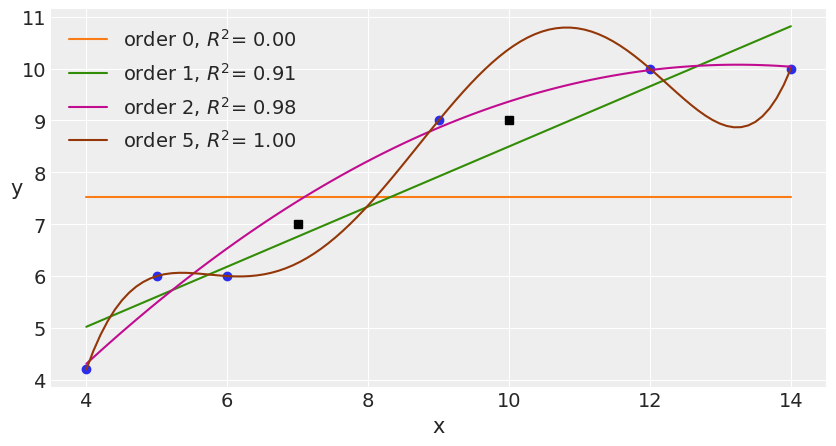

In [9]:
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)

    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_05_05.png', dpi=300)
plt.plot([10, 7], [9, 7], 'ks')
plt.savefig('B11197_05_06.png', dpi=300)

## Computing information criteria with PyMC3

In [10]:
waic_l = az.waic(trace_l)
waic_l

,waic,waic_se,p_waic,warning
0,28.644649,5.299565,2.40088,0


In [11]:
cmp_df = az.compare({'model_l':trace_l, 'model_p':trace_p}, method='BB-pseudo-BMA')
cmp_df

,waic,pwaic,dwaic,weight,se,dse,warning
model_p,9.20533,2.64384,0,0.998726,5.3029,0,0
model_l,28.6446,2.40088,19.4393,0.00127447,4.41145,5.31581,0


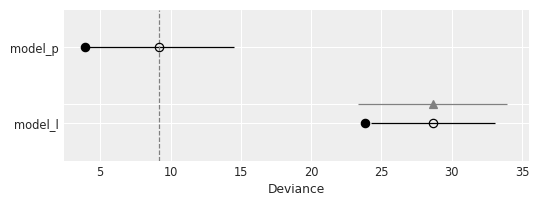

In [12]:
az.plot_compare(cmp_df)
plt.savefig('B11197_05_08.png', dpi=300)

## Model Averaging

In [13]:
w = 0.5
y_lp = pm.sample_posterior_predictive_w([trace_l, trace_p], samples=1000, models=[model_l, model_p],
                                        weights=[w, 1-w])

100%|██████████| 1000/1000 [00:00<00:00, 1921.53it/s]


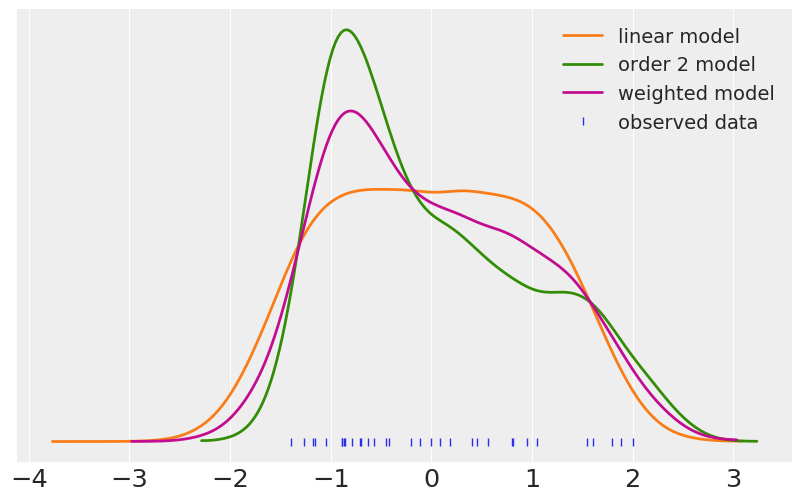

In [14]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_l, plot_kwargs={'color': 'C1'}, label='linear model', ax=ax)
az.plot_kde(y_p, plot_kwargs={'color': 'C2'}, label='order 2 model', ax=ax)
az.plot_kde(y_lp['y_pred'], plot_kwargs={'color': 'C3'},
           label='weighted model', ax=ax)

plt.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')
plt.yticks([])
plt.legend()
plt.savefig('B11197_05_09.png', dpi=300)

# Bayes factors

In [15]:
coins = 30 # 300
heads = 9 # 90
y_d = np.repeat([0, 1], [coins-heads, heads])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:08<00:00, 1265.19draws/s]


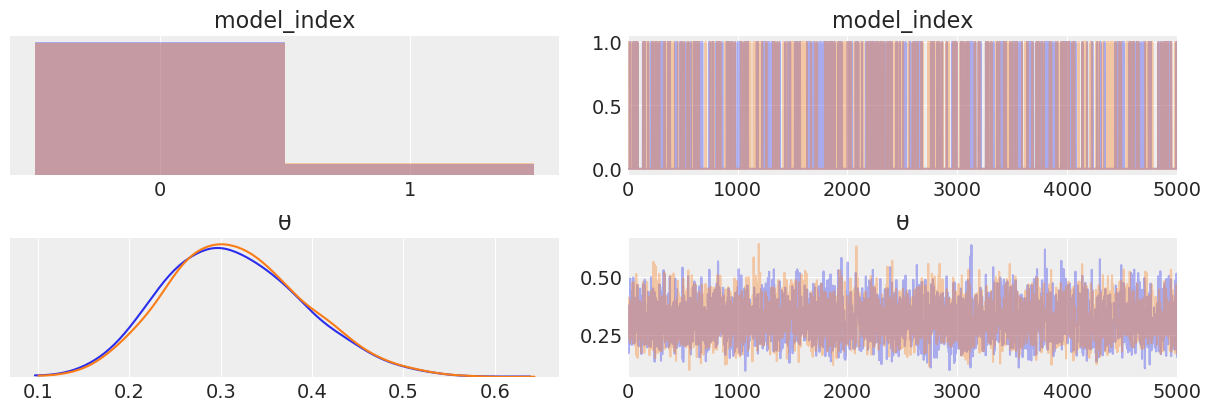

In [16]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)

    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

    # a priori
    θ = pm.Beta('θ', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', θ, observed=y_d)

    trace_BF = pm.sample(5000)
az.plot_trace(trace_BF)
plt.savefig('B11197_05_11.png', dpi=300)

In [17]:
pM1 = trace_BF['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])
BF

11.468827930174564

In [18]:
with pm.Model() as model_BF_0:
    θ = pm.Beta('θ', 4, 8)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_0 = pm.sample(2500, step=pm.SMC())

with pm.Model() as model_BF_1:
    θ = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_1 = pm.sample(2500, step=pm.SMC())

Sample initial stage: ...
Stage: 0 Beta: 1.000000 Steps: 25
100%|██████████| 2500/2500 [00:03<00:00, 814.48it/s]
Sample initial stage: ...
Stage: 0 Beta: 0.207520 Steps: 25
100%|██████████| 2500/2500 [00:02<00:00, 1007.92it/s]
Stage: 1 Beta: 0.692400 Steps: 4
100%|██████████| 2500/2500 [00:00<00:00, 5644.41it/s]
Stage: 2 Beta: 1.000000 Steps: 3
100%|██████████| 2500/2500 [00:00<00:00, 7651.69it/s]


In [19]:
model_BF_0.marginal_likelihood / model_BF_1.marginal_likelihood

10.984449130773804

## Bayes factors and information criteria

In [20]:
traces = []
waics = []
for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed=y_d)
            trace = pm.sample(2000)
            traces.append(trace)
            waics.append(az.waic(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:01<00:00, 2890.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 1914.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2091.16draws/s]
The acceptance probability does not match the target. It is 0.8805046845578458, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2384.85draws/s]
The acceptance probability d

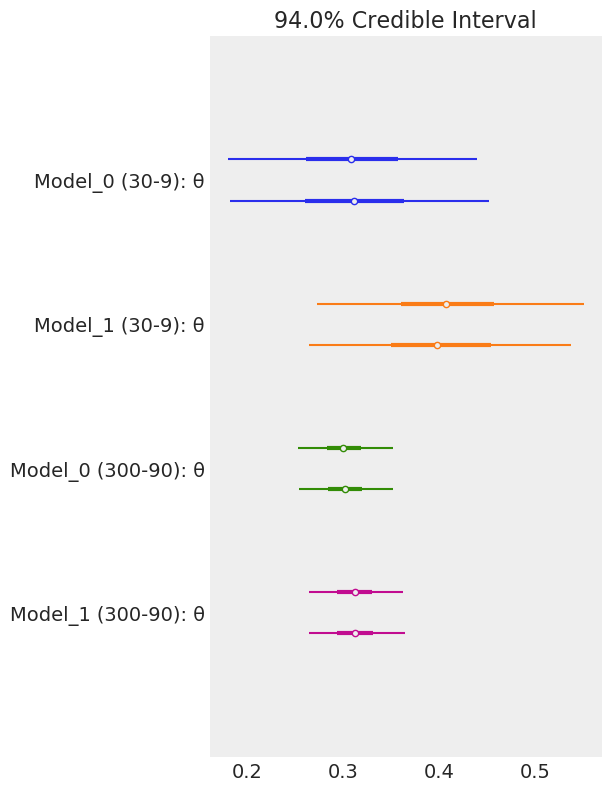

In [21]:
model_names = ['Model_0 (30-9)', 'Model_1 (30-9)',
               'Model_0 (300-90)', 'Model_1 (300-90)']

az.plot_forest(traces, model_names=model_names)
plt.savefig('B11197_05_12.png', dpi=300)

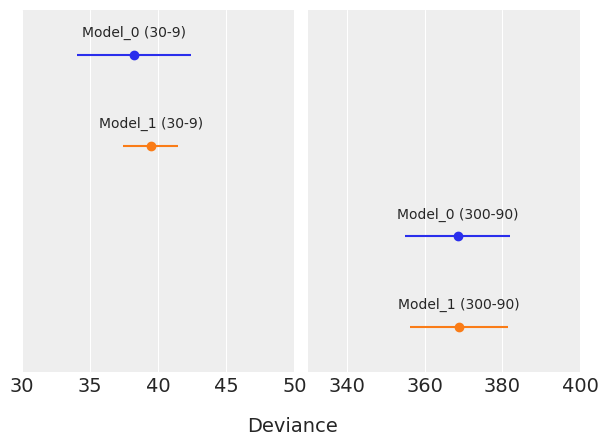

In [22]:
fig, ax = plt.subplots(1, 2, sharey=True)

labels = model_names
indices = [0, 0, 1, 1]
for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    ax[ind].errorbar(mean, -i, xerr=d.waic_se, fmt='o')
    ax[ind].text(mean, -i+0.2, labels[i], ha='center')

ax[0].set_xlim(30, 50)
ax[1].set_xlim(330, 400)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
plt.subplots_adjust(wspace=0.05)
fig.text(0.5, 0, 'Deviance', ha='center', fontsize=14)
plt.savefig('B11197_05_13.png', dpi=300)

## Regularizing priors

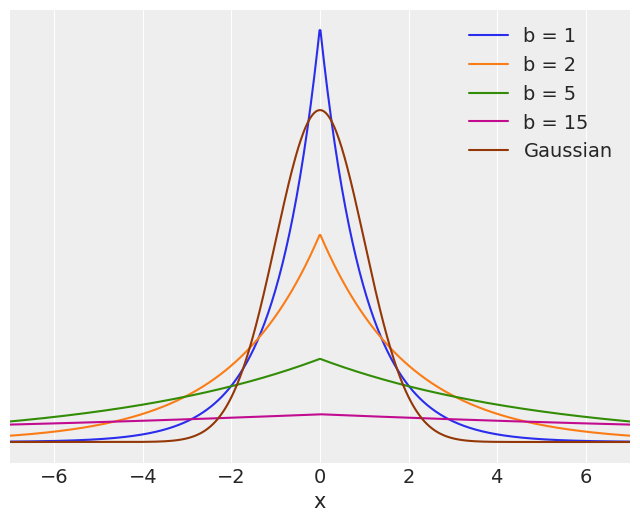

In [23]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 1000)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=f'b = {df}')

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-7, 7)
plt.savefig('B11197_05_14.png', dpi=300)

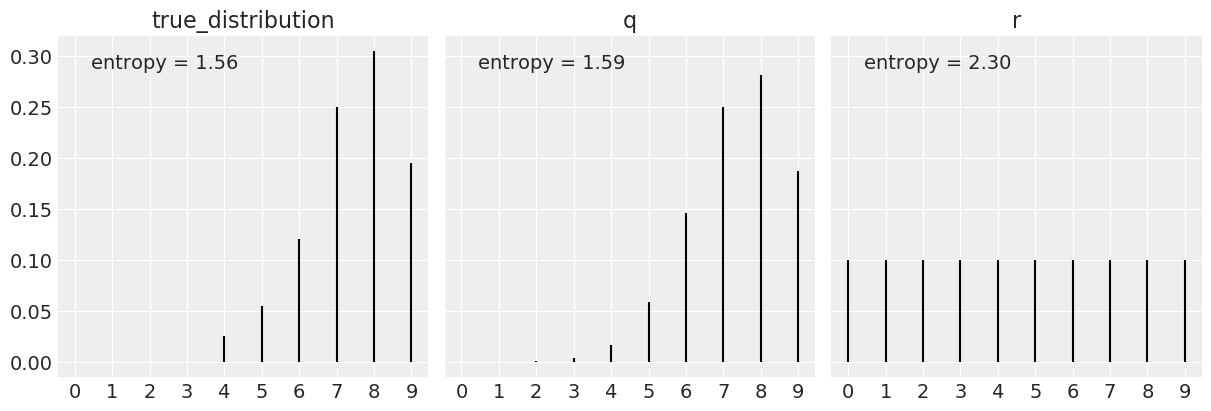

In [24]:
np.random.seed(912)
x = range(0, 10)
q = stats.binom(10, 0.75)
r = stats.randint(0, 10)

true_distribution = [list(q.rvs(200)).count(i) / 200 for i in x]

q_pmf = q.pmf(x)
r_pmf = r.pmf(x)

_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True,
                     constrained_layout=True)

for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf], ['true_distribution', 'q', 'r'])):
    ax[idx].vlines(x, 0, dist, label=f'entropy = {stats.entropy(dist):.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

plt.savefig('B11197_05_15.png', dpi=300)

In [25]:
stats.entropy(true_distribution, q_pmf), stats.entropy(true_distribution, r_pmf)

(0.009657896086383405, 0.7394593875511319)

In [26]:
stats.entropy(r_pmf, q_pmf), stats.entropy(q_pmf, r_pmf)

(2.756929658156367, 0.7154903060638594)